# Special case: gaseous molecules
In this short special case tutorial we will discuss how to handle gaseous molecules such as $CO_2$, $O_2$ or other gaseous compounds either produced or consumed. 

First, we will setup the environment and load the testing dataset.

In [1]:
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from pseudobatch import pseudobatch_transform_pandas
from pseudobatch.datasets import load_standard_fedbatch
from pseudobatch.datasets._dataloaders import _prepare_simulated_dataset

/Users/s143838/.virtualenvs/pseudobatch-dev/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'stan_version_major': '2', 'stan_version_minor': '29', 'stan_version_patch': '2', 'STAN_THREADS': 'false', 'STAN_MPI': 'false', 'STAN_OPENCL': 'false', 'STAN_NO_RANGE_CHECKS': 'false', 'STAN_CPP_OPTIMS': 'false'}


In [2]:
# fedbatch_df = load_standard_fedbatch()
fedbatch_df = _prepare_simulated_dataset("../../../article/data/standard_fed-batch_process.csv", sampling_points_only=True)

To pseudo batch transform a gaseous product or substrate one needs a vector of the accumulated production or consumption of the species in mass or mole units. Then we will pretend that gaseous species stayed in aqueous solution, and calculated the resulting concentration by dividing the accumulated production or consumption by the volume of the bioreactor. We can then perform the pseudo batch transformation on the concentration of the gaseous species. 

$$
\psi(t) = C_{aq, \: species}(t) + \frac{m_{gas, \: species}(t)}{V(t)}
$$

This approach assumes that the amount of molecules actually in aqueous solution is neglectable compared to amount of the accumulated gaseous molecule produced.


The test dataset contain simulated the accumulated $CO_2$ production in mass units in the column `m_CO2`.

<Axes: xlabel='timestamp'>

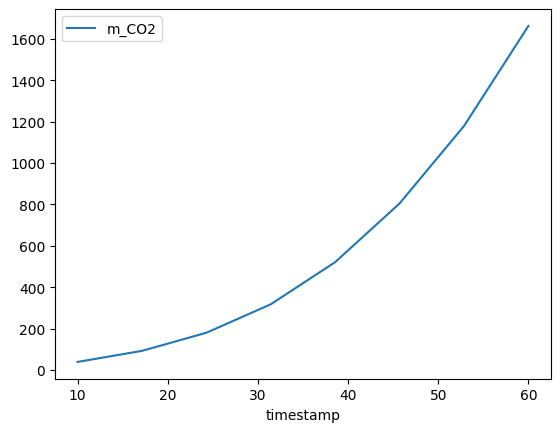

In [3]:
fedbatch_df.plot(x='timestamp', y='m_CO2')

<Axes: xlabel='timestamp'>

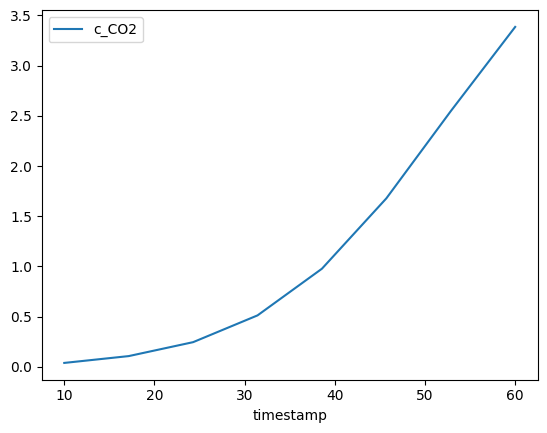

In [4]:
fedbatch_df.plot(x='timestamp', y='c_CO2')

<Axes: xlabel='m_Biomass'>

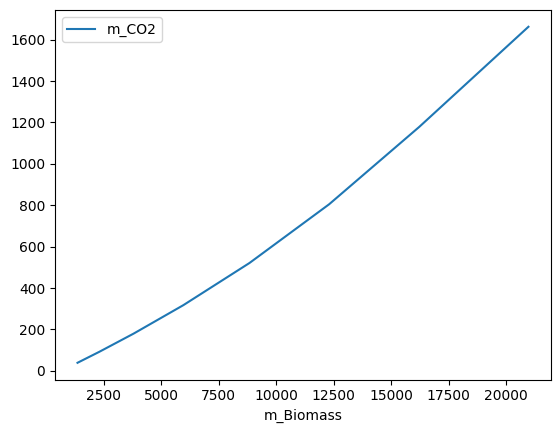

In [5]:
fedbatch_df.plot(x='m_Biomass', y='m_CO2')

<Axes: xlabel='timestamp'>

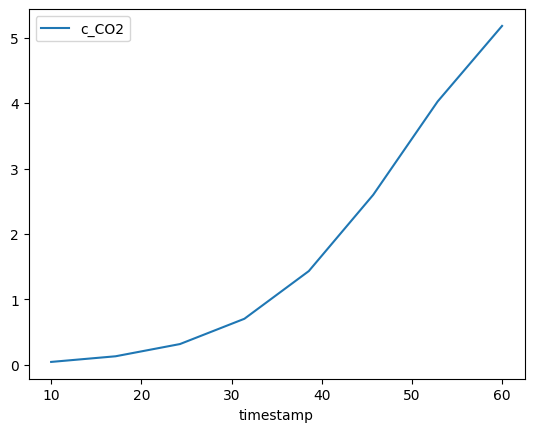

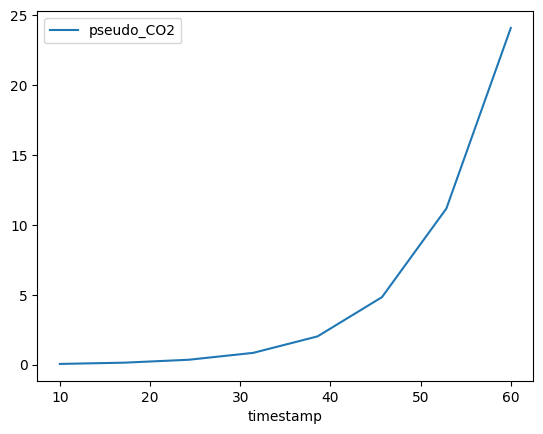

In [6]:
fedbatch_df['c_CO2'] = fedbatch_df['m_CO2'] / (fedbatch_df['v_Volume']-fedbatch_df['sample_volume'])
fedbatch_df.plot(x='timestamp', y='c_CO2')
fedbatch_df[['pseudo_Biomass', 'pseudo_CO2']] = pseudobatch_transform_pandas(
    df=fedbatch_df,
    measured_concentration_colnames=["c_Biomass", "c_CO2"],
    reactor_volume_colname='v_Volume',
    accumulated_feed_colname='v_Feed_accum',
    concentration_in_feed=[0,0],
    sample_volume_colname='sample_volume'
)
fedbatch_df.plot(x='timestamp', y='pseudo_CO2')

In [7]:
def gaseus_pseudo_species(pseudo_concentration, sample_volume, reactor_volume):
    sampling_fraction = sample_volume / reactor_volume
    return pseudo_concentration - (pseudo_concentration * sampling_fraction).cumsum()

fedbatch_df['pseudo_CO2_gaseous'] = gaseus_pseudo_species(
    fedbatch_df['pseudo_CO2'],
    fedbatch_df['sample_volume'],
    fedbatch_df['v_Volume']
)

In [8]:
def abline(slope, intercept, plot_kwargs=None):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--', **plot_kwargs)

In [9]:
Yxco2_hat, intercept = np.polyfit(fedbatch_df['pseudo_Biomass'], fedbatch_df['pseudo_CO2_gaseous'], 1)
print(f"Yxco2_hat = {Yxco2_hat}")
print(f"true Yxco2 = {fedbatch_df['Yxco2'].iloc[-1]}")

Yxco2_hat = 0.04519333244521414
true Yxco2 = 0.0451933324452141


Text(0, 0.5, 'pseudo_CO2')

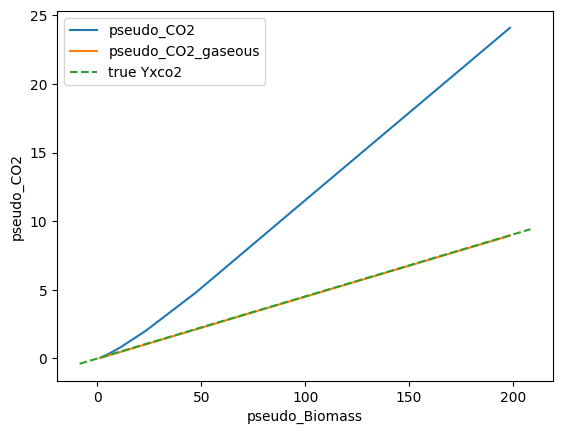

In [10]:

fedbatch_df.plot(x='pseudo_Biomass', y=['pseudo_CO2','pseudo_CO2_gaseous'])
abline(fedbatch_df.Yxco2.iloc[0], 0, plot_kwargs={'label': 'true Yxco2'})
plt.legend()
plt.ylabel('pseudo_CO2')

<Axes: xlabel='timestamp'>

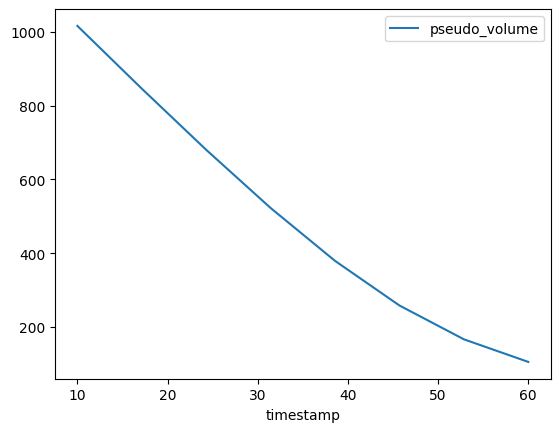

In [11]:
from pseudobatch.data_correction import accumulated_dilution_factor
fedbatch_df['accumulated_dilution_factor'] = accumulated_dilution_factor(
    after_sample_reactor_volume=fedbatch_df['v_Volume']-fedbatch_df['sample_volume'],
    sample_volume=fedbatch_df['sample_volume']
)
fedbatch_df['pseudo_volume'] = fedbatch_df['v_Volume'] / fedbatch_df['accumulated_dilution_factor']
fedbatch_df.plot(x='timestamp', y='pseudo_volume')

<Axes: xlabel='pseudo_Biomass'>

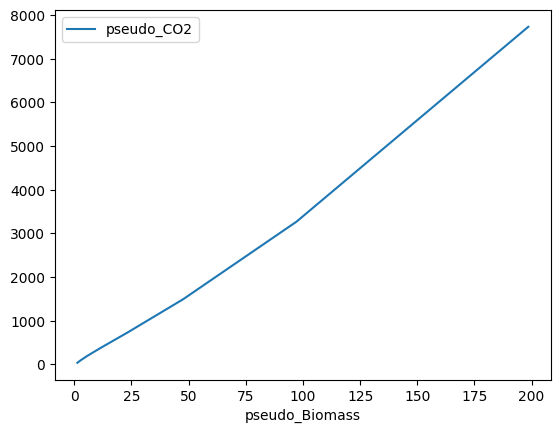

In [12]:
(fedbatch_df
    .assign(pseudo_CO2=fedbatch_df['m_CO2'] * fedbatch_df['accumulated_dilution_factor'])
    .plot(x='pseudo_Biomass', y='pseudo_CO2')
)


$$
C^{\star gas}_{CO2}(t) = C^\star_{CO2}(t) – \sum_{i=0}^t \frac{C^\star_{CO2}(t) * S(t)}{V(t)}
$$
$$
C^{\star gas}_{CO2}(t) = C_{CO2}(t) * ADF(t) – \sum_{i=0}^t ADF(i) * \frac{C_{CO2}(i) * S(i)}{V(i)}
$$

## Pretreatment implementation

$$
C_{CO2}^{adj}(t) = \frac{m_{CO2} - \sum_0^t m_{CO2}^{lost}}{V(t) - S(t)} = \frac{m_{CO2} - \sum_{i=0}^t \frac{m_{CO2}(i) * S(i)}{V(i)}}{V(t) - S(t)}
 
$$
This equation is not matching the one in Tims spreadsheet. That I realised that the equation is more complicated than I initially thought. Thus, I maybe best to use my pseudo batch transformation method and have a method to prepare the concentration in the correct format, i.e. total mass divided by volume after sampling.

$$
m
$$

```python
total_co2_mass = total_mass_of_species()
pseudo_batch_transform_gas(
    total_co2_mass,
    reactor_volume,
    samples_volume,
    ...
)
```

Adding to current:
```python
pseudo_batch_transform(
    measured_concentration,
    reactor_volume,
    ...
    is_gaseous=None,
)
```

Preprocessing function
```python
total_co2_mass = total_mass_of_species()
df['preprocessed_CO2'] = prepare_measurements_of_gaseous_specie(
    total_mass,
    reactor_volume,
    sampling_volume,
)
```

In [28]:
from numpy.typing import ArrayLike
def total_mass_of_gaseous_species(aqeous_concentration: ArrayLike, reactor_volume: ArrayLike, gaseous_mass: ArrayLike) -> ArrayLike:
    """Calculate total mass of gaseous species produced during the process.

    Parameters
    ----------
    aqeous_concentration : ArrayLike
        Aqueous concentration of the specie.
    reactor_volume : ArrayLike
        Reactor volume BEFORE sampling.
    gaseous_mass : ArrayLike
        Mass of gaseous specie produced. This is typically obtained from 
        integration of the rate measurements in the off-gas.
    
    Returns
    -------
    ArrayLike
        Total mass of gaseous specie produced.
    """

    return aqeous_concentration * reactor_volume + gaseous_mass

def sampling_adjusted_gas_concentration(
    total_mass_of_gaseous_species: ArrayLike,
    reactor_volume: ArrayLike,
    sample_volume: ArrayLike,
) -> ArrayLike:
    """Calculate the concentration of gaseous species in the reactor after sampling.

    Parameters
    ----------
    total_mass_of_gaseous_species : ArrayLike
        Total mass of gaseous specie produced.
    reactor_volume : ArrayLike
        Reactor volume BEFORE sampling.
    sample_volume : ArrayLike
        Sample volume.
   
    Returns
    -------
    ArrayLike
        Counter factual liquid concentration of gaseous species, if the gas specie
        did not evaporate.
    """
    # If gas specie did not evaporate some mass would be removed during sampling
    # this lost mass is calculate here.
    accumulated_mass_loss_due_to_sampling = np.array([])
    for i in range(len(total_mass_of_gaseous_species)):
        if i == 0:
            accumulated_mass_loss_due_to_sampling = np.append(
                accumulated_mass_loss_due_to_sampling,
                total_mass_of_gaseous_species[i] * sample_volume[i] / reactor_volume[i]
            )
            continue

        accumulated_mass_loss_due_to_sampling = np.append(
            accumulated_mass_loss_due_to_sampling,
            (
                ((total_mass_of_gaseous_species[i] - accumulated_mass_loss_due_to_sampling[i-1]) * sample_volume[i] / reactor_volume[i]) 
                + accumulated_mass_loss_due_to_sampling[i-1]
            )
        ) 
    
    return (total_mass_of_gaseous_species - accumulated_mass_loss_due_to_sampling) / (reactor_volume - sample_volume)

def preprocess_gas_species(aqeous_concentration, reactor_volume, gaseous_mass, sample_volume):
    total_mass_of_gaseous_species_ = total_mass_of_gaseous_species(
        aqeous_concentration=aqeous_concentration,
        reactor_volume=reactor_volume,
        gaseous_mass=gaseous_mass
    )

    preprocessed_concentration = sampling_adjusted_gas_concentration(
        total_mass_of_gaseous_species=total_mass_of_gaseous_species_,
        reactor_volume=reactor_volume,
        sample_volume=sample_volume
    )

    return preprocessed_concentration

In [29]:

def sampling_adjusted_gas_concentration(
    total_mass_of_gaseous_species: np.ndarray,
    reactor_volume: np.ndarray,
    sample_volume: np.ndarray
) -> np.ndarray:
    """Calculate the concentration of gaseous species in the reactor after sampling.

    Parameters
    ----------
    total_mass_of_gaseous_species : np.ndarray
        Total mass of gaseous species produced.
    reactor_volume : np.ndarray
        Reactor volume BEFORE sampling.
    sample_volume : np.ndarray
        Sample volume.
   
    Returns
    -------
    np.ndarray
        Counterfactual liquid concentration of gaseous species if the gas species
        did not evaporate.
    """
    # Initialize an empty array to store the accumulated mass loss due to sampling.
    accumulated_mass_loss_due_to_sampling = np.zeros_like(total_mass_of_gaseous_species)

    # Calculate the accumulated mass loss due to sampling.
    for i in range(len(total_mass_of_gaseous_species)):
        if i == 0:
            # The first element of the array is calculated differently.
            accumulated_mass_loss_due_to_sampling[i] = total_mass_of_gaseous_species[i] * sample_volume[i] / reactor_volume[i]
        else:
            accumulated_mass_loss_due_to_sampling[i] = (
                (total_mass_of_gaseous_species[i] - accumulated_mass_loss_due_to_sampling[i-1]) * sample_volume[i] / reactor_volume[i]
                + accumulated_mass_loss_due_to_sampling[i-1]
            )

    # Calculate the sampling-adjusted gas concentration for each gaseous species.
    sampling_adjusted_concentration = (total_mass_of_gaseous_species - accumulated_mass_loss_due_to_sampling) / (reactor_volume - sample_volume)
    
    return sampling_adjusted_concentration


<Axes: xlabel='pseudo_Biomass'>

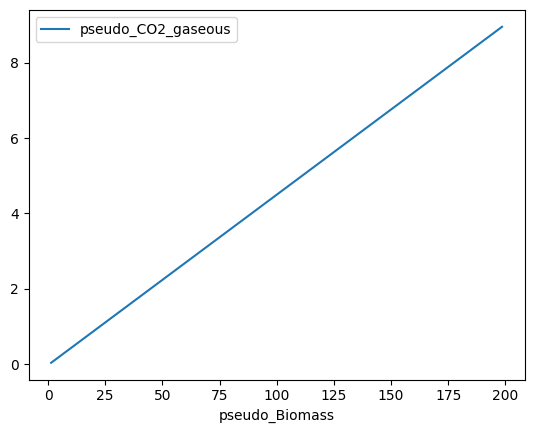

In [30]:
fedbatch_df['preprocessed_CO2'] = preprocess_gas_species(
    aqeous_concentration=np.zeros_like(fedbatch_df['m_CO2'].values),
    reactor_volume=fedbatch_df['v_Volume'].values,
    gaseous_mass=fedbatch_df['m_CO2'].values,
    sample_volume=fedbatch_df['sample_volume'].values
)
fedbatch_df[['pseudo_Biomass', 'pseudo_CO2_gaseous']] = pseudobatch_transform_pandas(
    df=fedbatch_df,
    measured_concentration_colnames=["c_Biomass", "preprocessed_CO2"],
    reactor_volume_colname='v_Volume',
    accumulated_feed_colname='v_Feed_accum',
    concentration_in_feed=[0,0],
    sample_volume_colname='sample_volume'
)
fedbatch_df.plot(x='pseudo_Biomass', y='pseudo_CO2_gaseous')

<Axes: xlabel='timestamp'>

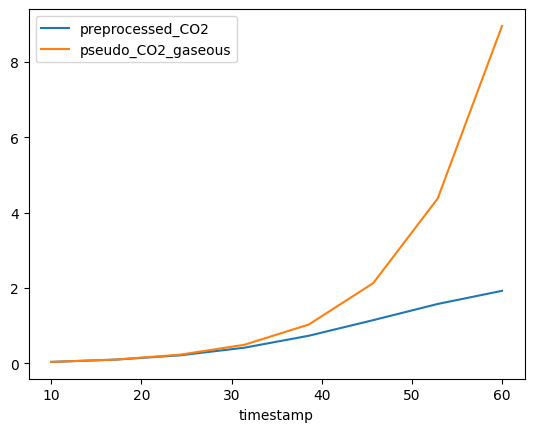

In [21]:
fedbatch_df.plot(x='timestamp', y=['preprocessed_CO2','pseudo_CO2_gaseous'])

In [16]:
fedbatch_df['preprocessed_CO2']


0    3.821923e-02
1   -4.535142e-02
2   -9.049726e+00
3   -1.031898e+03
4   -2.135463e+05
5   -7.173602e+07
6   -3.290722e+10
7   -1.731356e+13
Name: preprocessed_CO2, dtype: float64